In [2]:
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sys, os

from functools import reduce


wk_dir = '/Users/jplab/Desktop/DAILY_CODE_DATA/2022-6/data/6-6_new_motif_heatmap'
os.chdir(wk_dir)

# bananaaaaaa!
minion = sys.float_info.min

In [3]:
known_motifs = [
    '/Users/jplab/Desktop/DAILY_CODE_DATA/2022-6/data/6-6_B14_very_uniq_region_obtain/NC_B_navieOverlap_knownResults.txt',
    '/Users/jplab/Desktop/DAILY_CODE_DATA/2022-6/data/6-6_B14_very_uniq_region_obtain/NC_D_navieOverlap_knownResults.txt',
    '/Users/jplab/Desktop/DAILY_CODE_DATA/2022-6/data/6-6_B14_very_uniq_region_obtain/NC_T_navieOverlap_knownResults.txt'
]

In [4]:
combined_score_list = []

for motif_path in known_motifs:

    df_combined_score = pd.DataFrame()

    # read each known motif
    file_suffix = '_knownResults.txt'
    sample_name = motif_path.split('/')[-1].split(file_suffix)[0]
    motif = pd.read_csv(motif_path, sep='\t',header=0)

    # process pvalue and turn to -log10(pvalue), if pvalue is greater than 0.01, then set it to 1
    motif.loc[motif['P-value'].astype(float) <= 0.01,'processed P-value'] = motif['P-value']
    motif.loc[motif['P-value'].astype(float) > 0.01,'processed P-value'] = 1.00

    motif['-Log10(P-value)'] = -np.lib.scimath.log10(motif['processed P-value'].astype(float) + minion)

    # process %T/%B, if %T/%B is less than 1.5, then set it to 0
    motif['%T/%B'] = motif['% of Target Sequences with Motif'].str.rstrip('%').astype('float') / motif['% of Background Sequences with Motif'].str.rstrip('%').astype('float')
    
    motif.loc[motif['%T/%B'].astype(float) <= 1.5,'processed %T/%B'] = 0
    motif.loc[motif['%T/%B'].astype(float) > 1.5,'processed %T/%B'] = motif['%T/%B']

    motif['combined_score'] = motif['-Log10(P-value)'] * motif['processed %T/%B'] + minion

    # df_combined_score[sample_name + 'row_index'] = motif['Motif Name']
    df_combined_score['Motif Name'] = motif['Motif Name']
    df_combined_score[sample_name] = motif['combined_score']

    combined_score_list.append(df_combined_score)

print(combined_score_list)

[                                            Motif Name  NC_B_navieOverlap
0     CTCF(Zf)/CD4+-CTCF-ChIP-Seq(Barski_et_al.)/Homer       3.717003e+03
1       NF-E2(bZIP)/K562-NFE2-ChIP-Seq(GSE31477)/Homer       2.217221e+03
2      Bach1(bZIP)/K562-Bach1-ChIP-Seq(GSE31477)/Homer       2.153569e+03
3    Nrf2(bZIP)/Lymphoblast-Nrf2-ChIP-Seq(GSE37589)...       2.070739e+03
4     NFE2L2(bZIP)/HepG2-NFE2L2-ChIP-Seq(Encode)/Homer       2.067426e+03
..                                                 ...                ...
435  OCT:OCT(POU,Homeobox)/NPC-OCT6-ChIP-Seq(GSE439...      2.225074e-308
436  Pax7(Paired,Homeobox)/Myoblast-Pax7-ChIP-Seq(G...      2.225074e-308
437  Cux2(Homeobox)/Liver-Cux2-ChIP-Seq(GSE35985)/H...      2.225074e-308
438  ZNF16(Zf)/HEK293-ZNF16.GFP-ChIP-Seq(GSE58341)/...      2.225074e-308
439  ZFP3(Zf)/HEK293-ZFP3.GFP-ChIP-Seq(GSE58341)/Homer      2.225074e-308

[440 rows x 2 columns],                                             Motif Name  NC_D_navieOverlap
0     CTCF(Z

In [5]:
df_merged_combine_score = reduce(lambda df1, df2: df1.merge(df2,  left_on='Motif Name', right_on='Motif Name', how='inner'), combined_score_list)
df_merged_combine_score.set_index('Motif Name', inplace=True)
df_merged_combine_score.to_csv('combined_score_list.tsv', sep='\t', index=True)

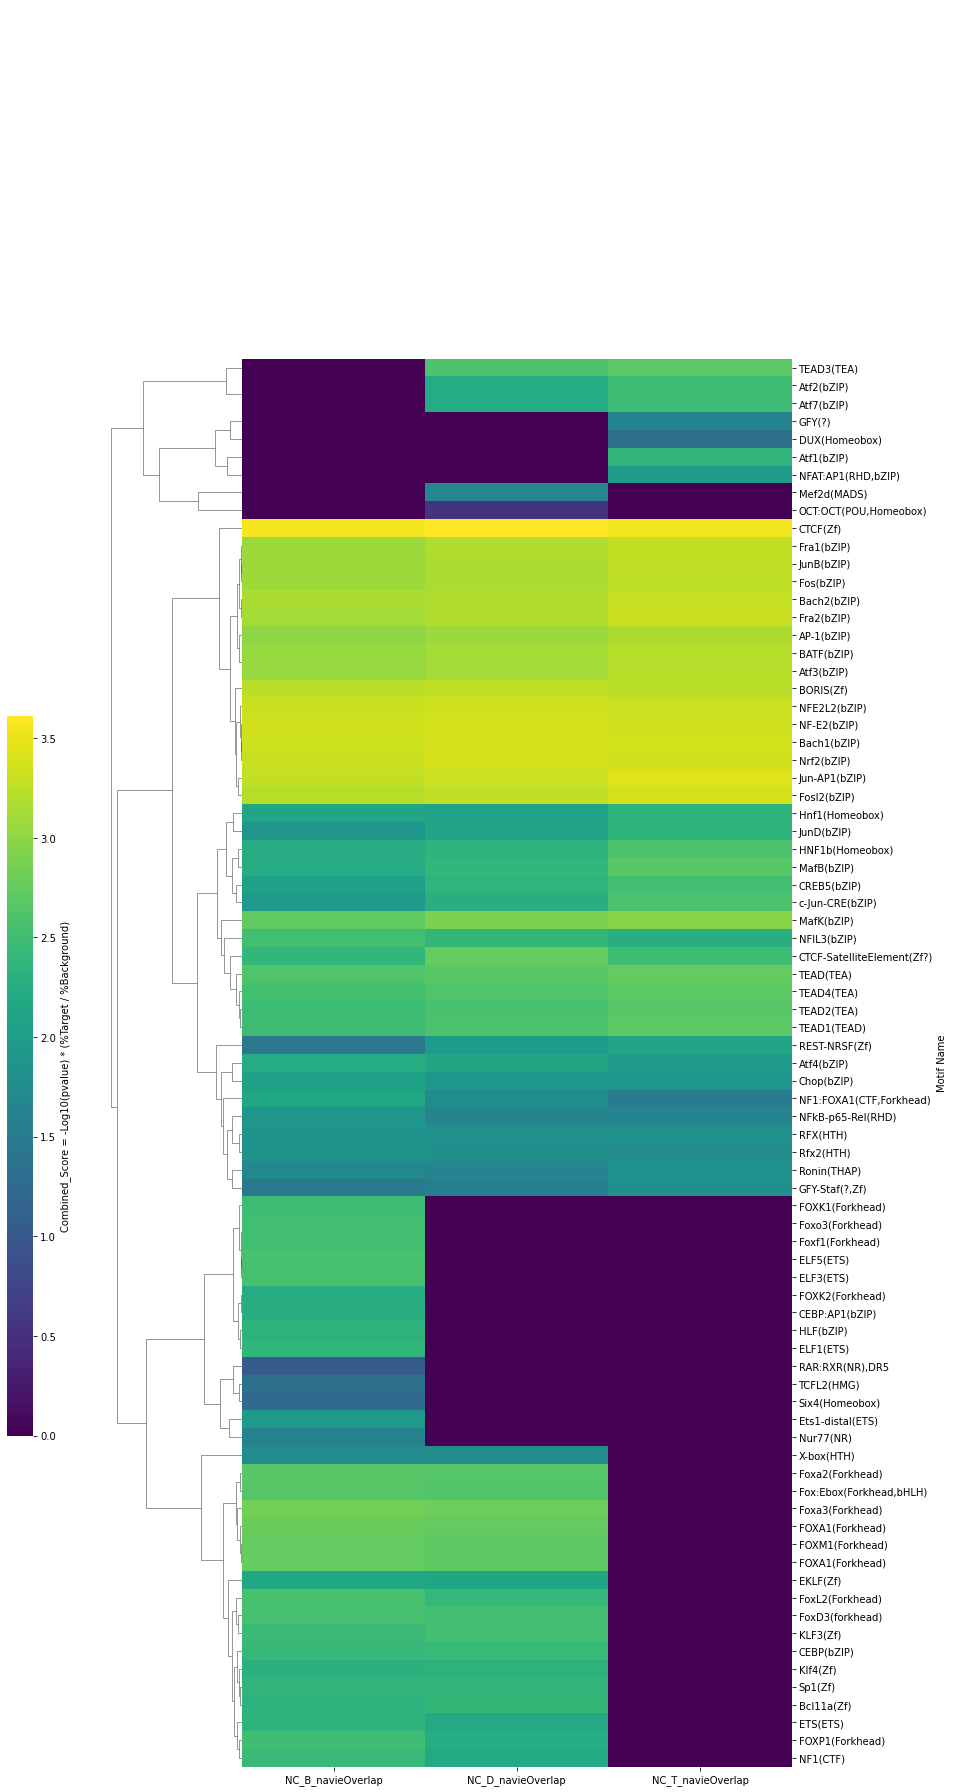

In [18]:
# before log transform, 0 value should be removed to avoid -inf issue
df_no_zero = df_merged_combine_score.loc[(df_merged_combine_score >= 1).any(axis=1)]

# df_no_zero.where(df_no_zero <= 1, 1, df_no_zero.columns),
# after log transfer, 0 value should be set to 1
log_transform_combined_score = np.log10(df_no_zero)
log_transform_combined_score[log_transform_combined_score < 0] = 0

# split index to shorter Motif name
new_index = log_transform_combined_score.index.to_series().str.split("/").str[0]
log_transform_combined_score.set_index(new_index, inplace=True)

# plot
ax = sns.clustermap(
    log_transform_combined_score, 
    cmap='viridis',
    # cmap='mako',
    row_cluster=True,
    col_cluster=False,
    # vmin=0,
    # vmax=4,
    figsize=(12,25),
    cbar_pos=(-0.1, .2, .03, .4),
    cbar_kws={'label':'Combined_Score = -Log10(pvalue) * (%Target / %Background)'},
    )
# plt.title('ATAC ncFOXA1 B1.14 DMSO TGF-beta MOTIF CLUSTERMAP', fontsize=20,loc='left')    

In [ ]:
sns.clustermap(
    df_merged_combine_score, 
    cmap='viridis',
    row_cluster=True,
    col_cluster=False,
    vmin=0,
    vmax=750,
    figsize=(12,120),
    cbar_pos=(0, .2, .03, .4)
    )

